In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [ ]:
train_data = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Narual language model/train-00000-of-00001.parquet")
test_data = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Narual language model/test-00000-of-00001.parquet")

In [ ]:
def into_paragraphs(data):
  all_text = ' '.join(data['text'].dropna().tolist())
  return re.sub(r'[^a-z\s]', '', all_text)

In [ ]:
train_df = into_paragraphs(train_data)
test_df = into_paragraphs(test_data)

In [ ]:
def get_batches(data, batch_size):
    for i in range(0, len(data) - batch_size, batch_size):
        return data[i:i + batch_size]


In [ ]:
train_df = get_batches(train_df, 5000)
test_df = get_batches(test_df, 500)

In [ ]:
import re

def processing(text: str):
  text = text.lower()
  corpus = re.sub(r'[^a-z\s]', '', text).split()
  vocab = sorted(set(corpus))
  vocab.append('<pad>')
  vocab.append('<unk>')
  word_2_id = {w: i for i, w in enumerate(vocab)}
  id_2_word = {i: w for i, w in enumerate(vocab)}
  text_id = [word_2_id[w] for w in corpus]

  return corpus, vocab, text_id, word_2_id, id_2_word

In [ ]:
corpus_train, vocab_train, text_id_train, word_2_id_train, id_2_word_train = processing(train_df)
corpus_test, vocab_test, text_id_test, word_2_id_test, id_2_word_test = processing(test_df)

In [ ]:
V = len(vocab_train)
D = 100
N = 5
n_hidden = 256
net = nn.Sequential(
    nn.Embedding(num_embeddings=V, embedding_dim=D),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Flatten(),
    nn.Linear(in_features=D*N, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=V)
)

In [ ]:
def text2id(text):
  corpus = text.lower()
  corpus = re.sub(r'[^a-z\s]', '', corpus).split()
  text_id = [word_2_id_train.get(w, V - 1) for w in corpus]
  return text_id


def predict(net: nn.Module, text: str, N: int):
  text_id = text2id(text)
  if len(text_id) < N:
    text_id = [word_2_id_train['<pad>']] * (N - len(text_id)) + text_id
  text_id = text_id[-N:]
  prob = net(torch.LongTensor(text_id).reshape(1, -1))
  prob = torch.softmax(prob, dim=1)
  next_word_id = torch.argmax(prob).item()
  return id_2_word_train[next_word_id], prob.detach().numpy()[0]



In [ ]:
import tqdm
def train(text_id: list, net: nn.Module, lr: float, optimizer: str, nepochs: int, N: int):
  fig,ax = plt.subplots(1,1)
  losses = []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=lr) if optimizer == "adam" else optim.SGD(net.parameters(), lr=lr)
  for ei in tqdm.trange(nepochs):
    for i in range(len(text_id) - N):
      inputs = torch.LongTensor(text_id[i:i+N]).reshape(1, -1)
      target = torch.LongTensor([text_id[i+N]])
      output = net(inputs)
      loss = criterion(output, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    fig.canvas.flush_events()
    # test()    # perplexity
  return net

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


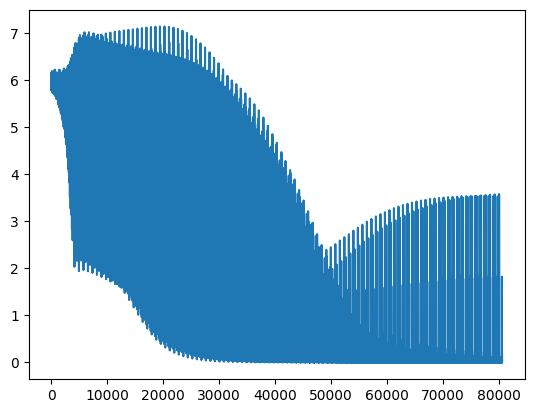

In [ ]:
model = train(text_id_train, net, 0.001, "sdd", 100, N = 5)

next_word='ega'

Prob
a 3.0501228170769223e-13
able 0.00010871760605368763
ach 4.383927716844482e-06
acquire 9.390276431986422e-07
act 5.832407055095246e-07
activate 1.924925709317904e-05
adapted 2.7327054340275936e-05
additional 6.018644126015715e-05
adjustments 0.0002654623531270772
affect 1.2923648682772182e-05
against 6.3141019381873775e-06
akeshi 9.071856766240671e-06
akimoto 0.00010648831084836274
alkyria 1.6101710571092553e-05
allia 2.394405055383686e-05
allian 4.1018072806764394e-05
along 4.160659955232404e-05
also 0.0003034660476259887
although 5.097046960145235e-05
always 8.191305823856965e-05
ameless 0.00015941698802635074
ameplay 2.759470021374e-07
an 1.8156920305045787e-06
and 9.270233192193444e-11
animated 2.6856462227442535e-06
animation 2.795506952679716e-05
anuary 2.0178877946364082e-07
apan 2.2583444447832335e-08
apanese 3.4525710361776873e-06
approach 1.5514626738877269e-06
ar 2.2915098725206917e-06
are 0.0011877681827172637
around 0.000996137736365199
as 1.251893451

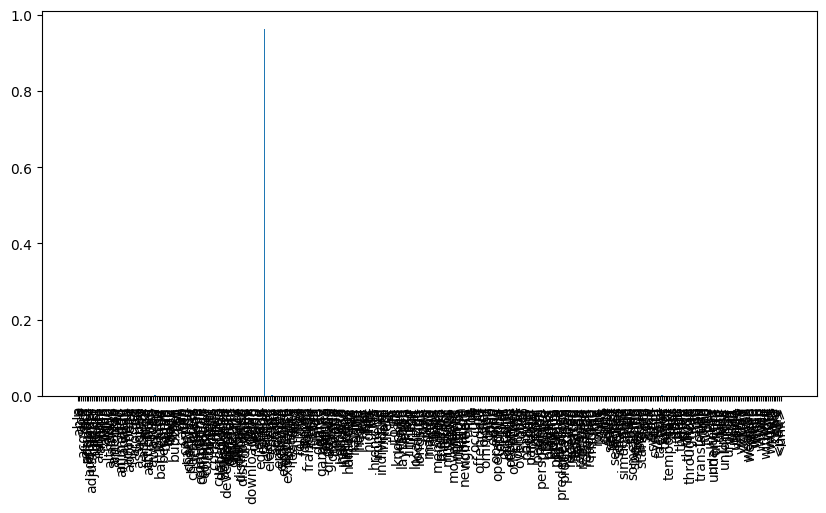

In [ ]:
next_word, prob = predict(model, "playing video game developed by", N=5)
print(f"{next_word=}")
print()
print("Prob")
print("\n".join([f"{id_2_word_train[i]} {prob[i]}" for i in range(len(prob))]))
plt.figure(figsize=(10, 5))
plt.bar(range(len(prob)), prob)
plt.xticks(range(len(prob)), id_2_word_train.values(), rotation=90)
plt.show()

In [ ]:
def perplexity(net: nn.Module, text: str, n: int):
    log_likelihood = 0.0
    total_words = len(text) - n  # Không tính từ đầu tiên vì không có dự đoán trước

    for i in range(total_words):
        input_seq = text[i:i + n]  # Chuỗi đầu vào
        target_word_id = text[i + n]  # Từ tiếp theo mà chúng ta cần dự đoán
        if target_word_id not in word_2_id_train:
           continue
        value = word_2_id_train[target_word_id]

        predicted_word, prob = predict(net, input_seq, N=n)

        target_prob = prob[value]
        log_likelihood += torch.log(torch.tensor(target_prob))

    avg_log_likelihood = log_likelihood / total_words
    return torch.exp(-avg_log_likelihood)

In [ ]:
perplexity(model, test_df, n= 5)

tensor(9.7076)